<h1 align="center"><b>Exploratory Data Analysis - Web Availability and CNAE in Spanish Companies</b></h1>
<h3 align="center"><b style="color:gray">Classification of Companies' Economic Activity: A Web Content and Machine Learning-Based Approach</b></h1>

<h3><b>Table of Contents</b></h3>
<ul style = "list-style-type: none; line-height: 0.5em;">
	<li><a href="#data"><h5>1. Data Sources</h5></a></li>
	<li><a href="#analysis"><h5>2. Data Analysis</h5></a></li>
    <ul style = "list-style-type: none;">
    	<li><a href="#analysis-availability"><h5>2.1. Web Availability</h5></a></li>
    	<li><a href="#analysis-employees"><h5>2.2. Employees Distribution</h5></a></li>
    	<li><a href="#analysis-province"><h5>2.3. Province Distribution</h5></a></li>
        <li><a href="#cnae"><h5>2.4. CNAE 2009</h5></a></li>
        <ul style = "list-style-type: none;">
        	<li><a href="#cnae-level1"><h5>2.4.1. Section (Level 1)</h5></a></li>
        	<li><a href="#cnae-level2"><h5>2.4.2. Division (Level 2)</h5></a></li>
        	<li><a href="#cnae-level3"><h5>2.4.3. Group (Level 3)</h5></a></li>
        	<li><a href="#cnae-level4"><h5>2.4.4. Class (Level 4)</h5></a></li>
        </ul>
        <li><a href="#distribution"><h5>2.5. Evaluating Sample Representativeness</h5></a></li>
    </ul>
	<li><a href="#conclusion"><h5>3. Conclusion</h5></a></li>
	<li><a href="#references"><h5>4. References</h5></a></li>
</ul>

In [1]:
# libraries
import os
import sys
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
sys.path.append(os.path.abspath(os.path.join("", "../src/")))
from utils.data import Data
pd.set_option("display.max_colwidth", 1000)
pd.set_option("display.float_format", "{:.8f}".format)
plt.style.use("ggplot")

<h2 id="data"><b>1. Data Sources</b></h2>
<div style="margin: 1em;">
    <h4><b>SABI</b></h4>
    <p style="text-align: justify;">
        The main dataset used in this exploratory data analysis (EDA) comes from SABI (Sistema de Análisis de Balances Ibéricos), a financial and business intelligence database that provides detailed
        information on companies in Spain and Portugal. SABI compiles data from various sources, including official registries, annual financial statements, and company reports, making it a reliable
        source for corporate analysis. 
        <br>
        The dataset includes multiple attributes that enable a comprehensive analysis of company characteristics. The most relevant variables are:
        <ul style="text-align: justify; margin: 0em 0em 1em 2em;">
            <li>Company Identification: Unique company identifiers, such as tax identification numbers (NIF) and business names.</li>
            <li>Number of Employees: Provides insights into the size of each company and allows for the study of business distribution based on workforce.</li>
            <li>Geographic Location: Includes information on the region and province where the company is based, which is useful for analyzing the territorial distribution of businesses in Spain.</li>
            <li>Website Status: Indicates whether a company has an active online presence, helping to assess the level of digitalization among businesses.</li>
            <li>CNAE Codes (Clasificación Nacional de Actividades Económicas): These codes classify businesses based on their economic activity.</li>
        </ul>
        <b>Source</b>: <a href="https://sabi.informa.es/">sabi.informa.es</a>
    </p>
    <h4><b>CNAE 2009</b></h4>
    <p style="text-align: justify;">
        In addition to the main dataset containing company information from SABI, a second dataset is used to map and structure the CNAE (Clasificación Nacional de Actividades Económicas) codes. This
        complementary dataset provides the hierarchical relationships between CNAE codes and their higher-level classifications, enabling a structured analysis of economic activities.
        Each CNAE code follows a hierarchical classification system that organizes economic activities into different levels of granularity:
        <ol style="text-align: justify; margin: 0em 0em 1em 2em;">
            <li>Section: The broadest level of classification, represented by a letter (e.g., "C" for Manufacturing).</li>
            <li>Division: A two-digit numerical code grouping related activities within a section (e.g., "10" for Food Industry).</li>
            <li>Group: A three-digit numerical code providing further subdivision (e.g., "101" for Meat Processing).</li>
            <li>Class (CNAE Code): The most specific level, represented by a four-digit code that precisely defines a business activity (e.g., "1011" for Processing and Preserving of Meat).</li>
        </ol>
        <b>Source</b>: <a href="https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736177032&menu=resultados&idp=1254735976614#_tabs-1254736195862">ine.es</a>
    </p>
    <h4><b>Main Activity Distribution in Spanish Companies</b></h4>
    <p style="text-align: justify;">
        This dataset contains the actual distribution of the main activity in Spanish companies in the year 2024. It includes the number of companies in each division (level 2 grouping). The objective of this 
        dataset is to study whether the sample used in this study is representative of the population.
        <br>
        <b>Source</b>: <a href="https://www.ine.es/jaxiT3/Tabla.htm?t=3954&L=0">ine.es</a>
    </p>
</div>

In [2]:
# load data
data = Data("../config/parameters.yaml")
sabi = data.sabi

<h2 id="analysis"><b>2. Data Analysis</b></h2>
<div style="margin: 1em;">
    <p style="text-align: justify;">
        This exploratory data analysis (EDA) examines the distribution of companies stored in the SABI database, specifically those with an active website. The analysis focuses on key aspects such as the
        number of employees, website availability, and geographic distribution across Spain. By studying these variables, the goal is to understand how companies are distributed in terms of workforce size
        and location, ensuring that the dataset is well-structured for further modeling. This step is essential to verify whether the data presents any significant imbalances that could affect subsequent
        classification tasks.
    </p>
    <p style="text-align: justify;">
        In addition to company distribution, this EDA provides a detailed examination of the classification of businesses according to the CNAE codes. The objective is to analyze the frequency and
        distribution of these codes across different classification levels, identifying which are most commonly used. This step is crucial for evaluating the balance of categories within the dataset, as
        the data will be used to develop a classification model. Understanding the distribution of CNAE codes ensures that the model training process is based on a well-represented and properly
        structured dataset.
    </p>
</div>

In [3]:
print("The dataset has {:,} rows (companies) and {} columns (features).".format(*sabi.shape))
sabi.head()

The dataset has 171,074 rows (companies) and 8 columns (features).


,nif,name,employees,province,url,primary_cnae,secondary_cnae,available
0,B93401248,LEGIO AGRIPINA SL.,2,Málaga,https://www.legioagripina.es/,6820,[],True
1,B03817459,ROLLSMATICA DEL SURESTE SL,5,Alicante,http://www.rollsmatica.es/,6202,"[4741, 4759]",True
2,B71141923,BEESY GESTION DE PROYECTOS SL.,2,Navarra,https://www.beesy.es/,7490,[7022],True
3,B02876019,REPACAR A.G.S. SOCIEDAD LIMITADA.,2,Castellón,http://www.repacarags.com/,4520,[],False
4,B66658188,KALCUS ADVANCE SL.,10,Madrid,https://www.lowcostenergia.es/,3514,[],True


<h3 style="margin-left: 1em;" id="analysis-availability"><b>2.1. Web Availability</b></h3>

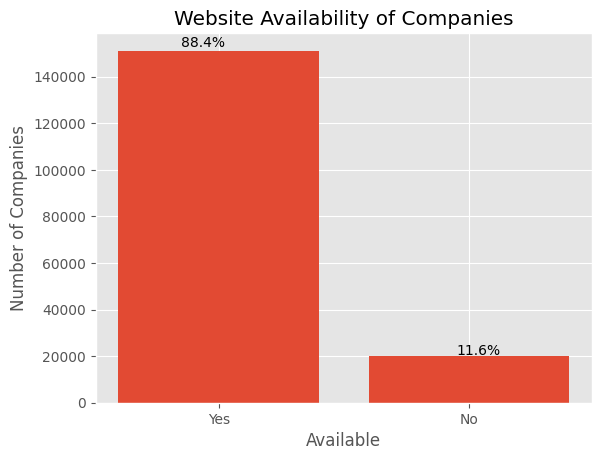

In [4]:
labels = ["Yes", "No"]
values = sabi["available"].value_counts().reindex([True, False], fill_value=0).to_list()
texts = [f"{value*100/sum(values):.1f}%" for value in values]

# Bar chart
plt.bar(labels, values)
plt.text(-0.15, values[0]+ 0.01*values[0], texts[0])
plt.text(0.95, values[1]+ 0.03*values[1], texts[1])
plt.title("Website Availability of Companies")
plt.ylabel("Number of Companies")
plt.xlabel("Available")
plt.show()

<h3 style="margin-left: 1em;" id="analysis-employees"><b>2.2. Employees Distribution</b></h3>

In [5]:
values = sabi["employees"].to_list()
size_categories = {
    "Micro": lambda x: x < 10,
    "Small": lambda x: 10 <= x < 50,
    "Mid-market": lambda x: 50 <= x < 250,
    "Large": lambda x: x >= 250
}
counts = {key: sum(cond(v) for v in values) for key, cond in size_categories.items()}
total = len(values)
proportions = {key: count / total for key, count in counts.items()}
print(f"{'Company Type':<15} | {'Companies':<10} | {'Proportion':<10}")
print("-" * 42)
for key in size_categories:
    print(f"{key:<15} | {counts[key]:^10,} | {proportions[key]:^10.2%}")

Company Type    | Companies  | Proportion
------------------------------------------
Micro           |  115,037   |   67.24%  
Small           |   48,926   |   28.60%  
Mid-market      |   6,916    |   4.04%   
Large           |    195     |   0.11%   


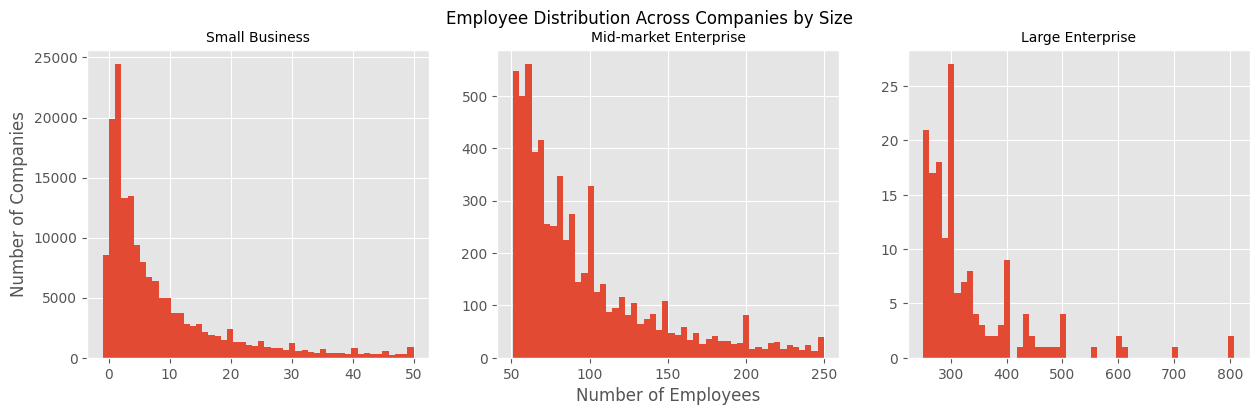

In [6]:
values = sabi["employees"].to_list()
small = [value for value in values if value <= 50]
medium = [value for value in values if 50 < value <= 250]
large = [value for value in values if 250 < value < 1000]

# Histogram
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4))
axs[0].hist(small, bins = 50)
axs[0].set_title("Small Business", size = 10)
axs[0].set_ylabel("Number of Companies")
axs[1].hist(medium, bins = 50)
axs[1].set_title("Mid-market Enterprise", size = 10)
axs[1].set_xlabel("Number of Employees")
axs[2].hist(large, bins = 50)
axs[2].set_title("Large Enterprise", size = 10)
fig.suptitle("Employee Distribution Across Companies by Size")
fig.show()

<h3 style="margin-left: 1em;" id="analysis-province"><b>2.3. Province Distribution</b></h3>

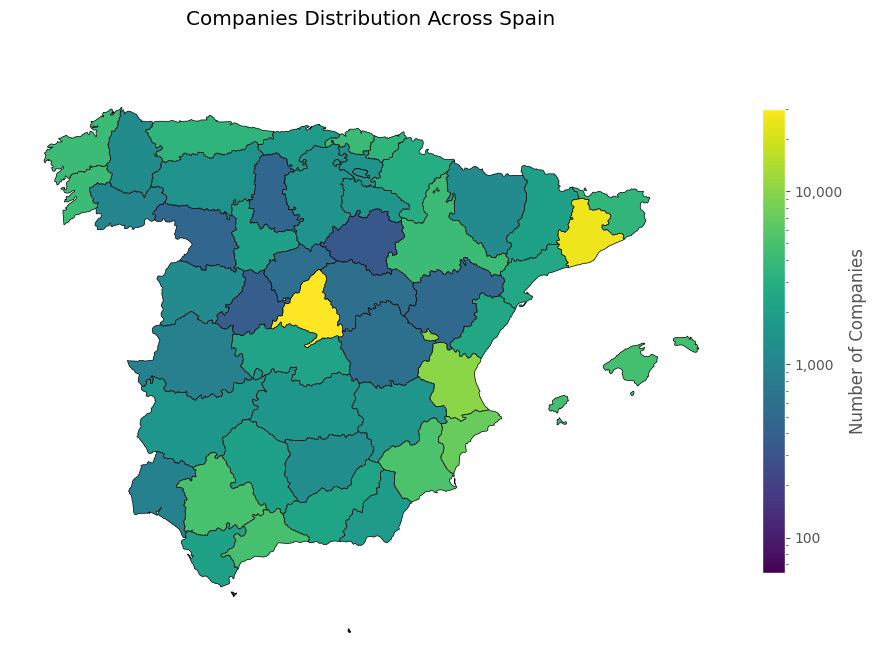

In [7]:
url = "https://simplemaps.com/static/svg/country/es/admin2/es.json"
response = requests.get(url)
geojson_data = response.json()
correct = {"Gerona":"Girona", "La Coruña":"a Coruña", "Álava":"Alava",
           "Orense":"Ourense", "Lérida":"Lleida", "Jaén":"Jaen", 
           "Ávila":"Avila", "Gipuzkoa":"Guipuzcoa", "Bizkaia":"Vizcaya",
           "Las Palmas":"Las Palmas de Gran Canaria"}
provinces = [feature["properties"]["name"] for feature in geojson_data["features"]]
provinces = [correct.get(prov, prov) for prov in provinces]
values = sabi["province"].value_counts().reindex(provinces, fill_value=0).to_list()

# Colormap
lognorm = mcolors.LogNorm(vmin=max(min(values), 1), vmax=max(values))
cmap = cm.viridis

# Map
fig, ax = plt.subplots(figsize=(10, 8))
patches = []
for feature, value in zip(geojson_data["features"], values):
    geometry = feature["geometry"]
    color = cmap(lognorm(value))
    if geometry["type"] == "Polygon":
        for polygon in geometry["coordinates"]:
            poly = Polygon(polygon, 
                           closed = True, 
                           edgecolor = "black", 
                           facecolor = color)
            patches.append(poly)
    
    elif geometry["type"] == "MultiPolygon":
        for multipolygon in geometry["coordinates"]:
            for polygon in multipolygon:
                poly = Polygon(polygon, 
                               closed = True, 
                               edgecolor = "black", 
                               facecolor = color)
                patches.append(poly)
p = PatchCollection(patches, match_original=True)
ax.add_collection(p)
cbar = plt.colorbar(cm.ScalarMappable(cmap = cmap, norm = lognorm),
                    ax = ax, 
                    fraction = 0.03, 
                    pad = 0.04)
cbar.set_label("Number of Companies")
cbar.set_ticks([10**v for v in range(2, 5)])
cbar.set_ticklabels(["{:,}".format(10**v) for v in range(2, 5)])
ax.set_xlim(-10, 5)
ax.set_ylim(35, 45)
ax.set_title("Companies Distribution Across Spain")
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
plt.show()

<h3 style="margin-left: 1em;" id="cnae"><b>2.4. CNAE 2009</b></h3>

<h4 style="margin-left: 2em;" id="cnae-level1"><b>2.4.1. Section (Level 1)</b></h4>

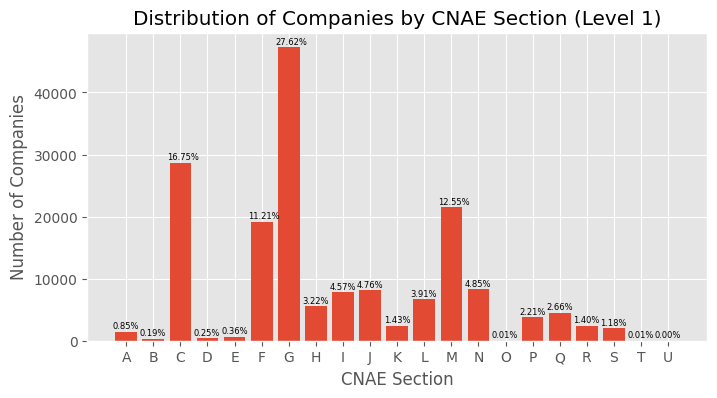

In [8]:
level_1 = data.load_with_label(level = 1)
level1_data = dict(sorted(level_1["label"].value_counts().to_dict().items()))
labels = level1_data.keys()
values = level1_data.values()
texts = [f"{value*100/sum(values):.2f}%" for value in values]

# Bar Chart
plt.figure(figsize = (8, 4))
plt.bar(labels, values)
for i, text in enumerate(texts):
    x, y = i-0.5, list(values)[i] + 500
    plt.text(x, y, text, size = 6)
plt.title("Distribution of Companies by CNAE Section (Level 1)")
plt.ylabel("Number of Companies")
plt.xlabel("CNAE Section")
plt.show()

<h4 style="margin-left: 2em;" id="cnae-level2"><b>2.4.2. Division (Level 2)</b></h4>

In [9]:
level_2 = data.load_with_label(level = 2)

temp = level_2.value_counts(subset=["label", "description"]).reset_index(name="count")
temp["percentaje"] = temp["count"]/sum(temp["count"])
temp["cum_percentaje"] = temp["percentaje"].cumsum()
temp["percentaje_t"] = temp["percentaje"].apply(lambda x: f"{x*100:.2f}%")
temp["count_t"] = temp["count"].apply(lambda x: f"{x:,}")
top_50 = temp.loc[temp["cum_percentaje"] <= 0.5, ["label", "description", "count_t", "percentaje_t"]]
top_50.columns = ["CNAE Division (Level 2)", "Description", "Number of Companies", "Percentaje"]
print("Divisions grouping 50% of Companies")
display(top_50)

Divisions grouping 50% of Companies


,CNAE Division (Level 2),Description,Number of Companies,Percentaje
0,46,"Comercio al por mayor e intermediarios del comercio, excepto de vehículos de motor y motocicletas","26,076",15.24%
1,47,"Comercio al por menor, excepto de vehículos de motor y motocicletas","15,012",8.78%
2,43,Actividades de construcción especializada,"12,114",7.08%
3,69,Actividades jurídicas y de contabilidad,"7,420",4.34%
4,68,Actividades inmobiliarias,"6,691",3.91%
5,41,Construcción de edificios,"6,393",3.74%
6,45,Venta y reparación de vehículos de motor y motocicletas,"6,171",3.61%
7,25,"Fabricación de productos metálicos, excepto maquinaria y equipo","5,604",3.28%


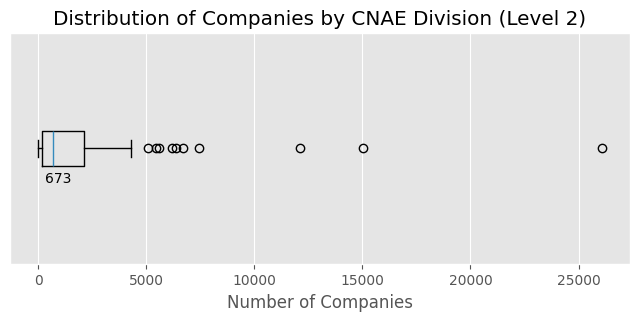

In [10]:
values = level_2.value_counts("label").reset_index(name="count")["count"].to_list()

# Box-Whisker 
median = int(np.median(values))
plt.figure(figsize = (8, 3))
plt.boxplot(values, vert = 0)
# plt.axvline(x = median, linestyle = "--", color = "black")
plt.text(median*0.5, 0.85, f"{median}")
plt.yticks([])
plt.title("Distribution of Companies by CNAE Division (Level 2)")
plt.xlabel("Number of Companies")
plt.show()

<h4 style="margin-left: 2em;" id="cnae-level3"><b>2.4.3. Group (Level 3)</b></h4>

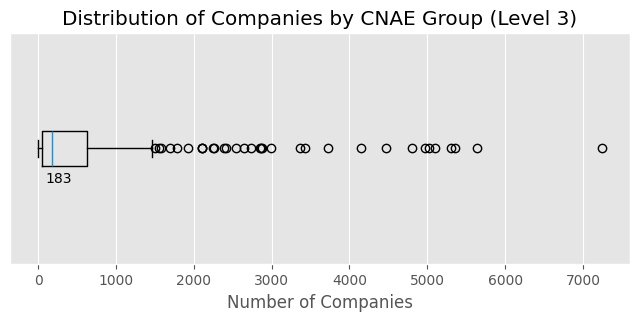

In [11]:
level_3 = data.load_with_label(level = 3)
values = level_3.value_counts("label").reset_index(name="count")["count"].to_list()

# Box-Whisker 
median = int(np.median(values))
plt.figure(figsize = (8, 3))
plt.boxplot(values, vert = 0)
# plt.axvline(x = median, linestyle = "--", color = "black")
plt.text(median*0.5, 0.85, f"{median}")
plt.yticks([])
plt.title("Distribution of Companies by CNAE Group (Level 3)")
plt.xlabel("Number of Companies")
plt.show()

<h4 style="margin-left: 2em;" id="cnae-level4"><b>2.4.4. Class (Level 4)</b></h4>

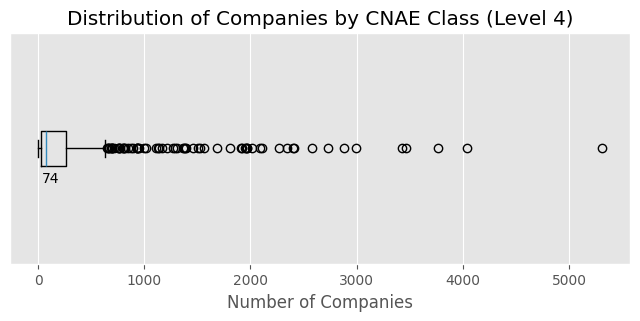

In [12]:
level_4 = data.load_with_label(level = 4)
values = level_4.value_counts("label").reset_index(name="count")["count"].to_list()

# Box-Whisker 
median = int(np.median(values))
plt.figure(figsize = (8, 3))
plt.boxplot(values, vert = 0)
plt.text(median*0.5, 0.85, f"{median}")
plt.yticks([])
plt.title("Distribution of Companies by CNAE Class (Level 4)")
plt.xlabel("Number of Companies")
plt.show()

<h3 id="distribution" style="margin-left: 1em"><b>2.5. Evaluating Sample Representativeness</b></h3>
<div style="margin: 1em;">
    <p style="text-align: justify;">
        In order to evaluate whether the selected sample is representative of the population, we will perform a Chi-square goodness-of-fit test. This statistical procedure allows us to compare the observed distribution of the sample with the expected distribution based on the population. We will set the significance level at 0.05, meaning that we will accept a 5% risk of rejecting the null hypothesis when it is actually true. The following hypotheses will be tested:
        <ul style = "list-style-type: none; line-height: 1.5em;">
            <li><b>Null Hypothesis (H<sub>0</sub>)</b>: The sample is representative of the population, meaning there is no significant difference between the observed and expected distributions.</li>
            <li><b>Alternative Hypothesis (H<sub>1</sub>)</b>: The sample is not representative of the population, indicating a significant difference between the observed and expected distributions.</li>
        </ul>
    </p>
</div>

In [13]:
level = 1

# Actual data distribution
original_distribution = data.load_distribution(level = level)
original_distribution.set_index("main_activity", inplace = True)

# Sample data distribution
sample = data.load_with_label(level = level)
sample_distribution = sample["label"].value_counts().reset_index()
sample_distribution.columns = ["main_activity", "count"]
sample_distribution.set_index("main_activity", inplace = True)

distribution_data = original_distribution.join(sample_distribution, how = "inner").reset_index()
distribution_data.columns = ["activity", "description", "original", "sample"]
categories = distribution_data["activity"].to_list()
observed = distribution_data["sample"].to_numpy()
expected = (distribution_data["original"].to_numpy()/sum(distribution_data["original"])) * sum(observed)

# Chi-Square goodness-of-fit Global Test
chi2_stat, p_value = stats.chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-Square Test Results:\n"
      f" - Test Statistic (Chi2): {chi2_stat:.3f}\n"
      f" - p-value: {p_value:.6f}\n"
      f" - Degrees of Freedom: {len(observed)-1}\n"
      f" - Null Hypothesis: {('Rejected' if p_value < 0.05 else 'Not Rejected')}")

# Calculate the individual contribution of each class
chi2_individual = (observed - expected) ** 2 / expected
p_values_individual = [1 - stats.chi2.cdf(chi2_i, df=1) for chi2_i in chi2_individual]
test_category = pd.DataFrame(
    {
        "Section": distribution_data["activity"].to_list(),
        "Description": distribution_data["description"].to_list(),
        "Observed": observed,
        "Expected": expected.astype(dtype = np.uint32),
        "Chi2": chi2_individual,
        "p-value": p_values_individual
    }
)

print("\nIndividual contribution of each class")
display(test_category)

Chi-Square Test Results:
 - Test Statistic (Chi2): 84735.794
 - p-value: 0.000000
 - Degrees of Freedom: 16
 - Null Hypothesis: Rejected

Individual contribution of each class


,Section,Description,Observed,Expected,Chi2,p-value
0,B,Industrias extractivas,318,79,716.40211171,0.00000000
1,C,Industria manufacturera,28650,8140,51675.63551780,0.00000000
2,D,"Suministro de energía eléctrica, gas, vapor y aire acondicionado",427,575,38.36956401,0.00000000
3,E,"Suministro de agua, actividades de saneamiento, gestión de residuos y descontaminación",619,362,180.98510066,0.00000000
4,F,Construcción,19180,19983,32.31030304,0.00000001
5,G,Comercio al por mayor y al por menor; reparación de vehículos de motor y motocicletas,47259,33090,6066.64287150,0.00000000
6,H,Transporte y almacenamiento,5514,10708,2519.91095673,0.00000000
7,I,Hostelería,7816,13752,2562.61306163,0.00000000
8,J,Información y comunicaciones,8139,3749,5138.69835249,0.00000000
9,K,Actividades financieras y de seguros,2450,3971,582.97466915,0.00000000


<h2 id="conclusion"><b>3. Conclusion</b></h2>
<div style="margin: 1em;">
    <p style="text-align: justify;">
        The initial dataset consists of approximately 171,000 companies, each with a linked URL. However, during the web scraping process, some errors occurred, resulting in a final dataset of around 150,000 companies. Despite this reduction, the dataset remains sufficiently large for training the classifier.
        <br>
        The first step was to assess whether the sample of companies exhibited a balanced distribution. To do so, we analyzed the number of employees and geographical distribution. The results indicate that the distribution of employees reflects the overall structure of Spanish companies, while the geographical distribution aligns with population density in Spain, with two major clusters of companies located in Madrid and Barcelona.
        <br>
        The most critical step was analyzing the distribution of CNAE codes at all four levels. At Level 1 (sections), we found that four out of the 21 categories account for more than two-thirds of the companies. A similar pattern emerges at the division level, where eight divisions comprise approximately 50% of the data. Since our goal is to develop a classifier for at least Level 3, we examined the number of companies per label. We found that 50% of the labels contain fewer than 183 companies. This trend persists at Level 4, where half of the labels have fewer than 74 companies.
        <br>
        A chi-squared test was conducted to assess the representativeness of the sample in terms of the distribution of CNAE codes at Level 2. The results indicate a significant difference between the sample distribution and the population distribution, leading to the rejection of the null hypothesis. Therefore, the sample is not representative of the population with respect to CNAE code distribution.
        <br>
        In conclusion, the dataset presents an unbalanced distribution in terms of CNAE codes, which must be considered during model training. However, the distributions of employees and geographical locations do not pose a concern, as they accurately reflect the structure of the Spanish economy, which is predominantly composed of small and mid-sized enterprises concentrated in the two main provinces. <a href = "#ref-1">[1]</a>
    </p>
</div>

<h2 id="references"><b>4. References</b></h2>
<div style="margin: 1em;">
    <p id="ref-1">
        <b>[1]</b> <b>Ministerio de Industria, Comercio y Turismo</b>, <i>Estructura y Dinámica Empresarial en España 2023</i>, Ministerio de Industria, Comercio y Turismo, España, 2023.
        <br>
        &emsp; &ensp;[Online]. Available: 
        <a href="https://industria.gob.es/es-es/estadisticas/Estadisticas_Territoriales/Estructura-Dinamica-Empresarial-2023.pdf" target="_blank">
            https://industria.gob.es/es-es/estadisticas/Estadisticas_Territoriales/Estructura-Dinamica-Empresarial-2023.pdf
        </a>
    </p>
</div>